In [1]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import scipy.stats as st

from google.cloud import bigquery
bqclient = bigquery.Client()

from matplotlib import pyplot as plt
import seaborn as sns
#import chartify


In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [3]:
def acc_type_definition(paid_flag, num_active_weeks, avg_active_users_view):
    if paid_flag == True:
        return 'paid'
    elif num_active_weeks > 2 and avg_active_users_view > 1:
        return 'free active (3+ weeks) with 2+ users'
    elif num_active_weeks > 2 and num_active_weeks <=8:
        return 'free active (3-8 weeks) with 1 user'
    elif num_active_weeks > 8:
        return 'free active (>8 weeks) with 1 user'
    elif avg_active_users_view > 1:
        return 'within trial active with 2+ users'
    else:
        return 'non-active after trial end'

#### Events query 

In [ ]:
sql_query = """
with trials as (
  SELECT
    date_trunc(date(trial_start_date), week(monday)) as trial_start_week,
    trial_start_date,
    paid_account ,
    account_id
  FROM `prodcloudna-analytics-team.ekaterina_zaitseva.base_registrations`
  WHERE entry_point in ('Web','Wrike Account Management')
  and first_account
  and is_reached_ws
  and date(trial_start_date) >= '2020-06-01'
  and registration_page_type = 'Pricing'
  and onboarding_trial_product = 'Free'
  ),

  activity as (
  SELECT
    partition_date,
    account_id,
    user_id,
    view,
    edit
  FROM `prodcloudna-de-production.product_aggregations.activity`
  WHERE partition_date >= '2020-06-01' and view + edit > 0
  ),

  active_users as (
  select
    t.trial_start_date,
    t.paid_account,
    t.account_id,
    date_trunc(a.partition_date, week(monday)) as activity_week,
    date_diff(date_trunc(a.partition_date, week(monday)), t.trial_start_week, week(monday)) as week_after_trial_start,
    count(distinct if(a.view > 0,a.user_id,null)) as active_users_view,
    count(distinct if(a.edit > 0,a.user_id,null)) as active_users_edit
  from trials t
  join activity a on t.account_id = a.account_id
  group by 1,2,3,4,5
  ),

  account_agg as (
  select
    trial_start_date,
    paid_account ,
    account_id ,
    count(distinct activity_week) num_active_weeks,
    max(activity_week) last_activity_week,
    max(week_after_trial_start) max_week_after_trial,
    round(avg(active_users_view)) avg_active_users_view,
    round(avg(active_users_edit)) avg_active_users_edit
  from
    active_users
  group by 1,2,3),
  
  events as (
  select
    account_id,
    partition_date,
    client_event,
    client_group,
    count(*) cnt_events
  from
    `prodcloudna-de-production.events.client` 
  where 
    partition_date > '2020-06-01'
  group by 1,2,3,4)
  
  select 
    date(aa.trial_start_date) trial_start_date,
    aa.* except (trial_start_date),
    e.client_event,
    e.client_group,
    sum(cnt_events) cnt_events
  from 
    account_agg aa
  left join 
    events e
    on aa.account_id = e.account_id
    and date_diff(e.partition_date,date(aa.trial_start_date), day) >= 0 
    and date_diff(e.partition_date,date(aa.trial_start_date), day) <= 14
  group by 1,2,3,4,5,6,7,8,9,10
"""

Took all front-end events for all accounts within 14 days since trial start date

In [4]:
sql = """
select * from `prodcloudna-analytics-team.ekaterina_zaitseva.free_accounts_first_14_days_events`
"""

In [5]:
%%time
free_events = bqclient.query(sql).result().to_dataframe()
free_events.head(3)

CPU times: user 42.6 s, sys: 1.37 s, total: 44 s
Wall time: 1min 18s


,trial_start_date,paid_account,account_id,num_active_weeks,last_activity_week,max_week_after_trial,avg_active_users_view,avg_active_users_edit,client_event,client_group,cnt_events
0,2020-06-19,False,3891228,2,2020-06-22,1,1.0,1.0,iframe_launch,wistia,1.0
1,2020-06-21,False,3893888,2,2020-06-22,1,1.0,1.0,shown,reg_form_detail,2.0
2,2020-06-26,False,3902234,1,2020-06-22,0,1.0,1.0,view_dependencies__click,None,2.0


In [6]:
free_events.columns

Index(['trial_start_date', 'paid_account', 'account_id', 'num_active_weeks',
       'last_activity_week', 'max_week_after_trial', 'avg_active_users_view',
       'avg_active_users_edit', 'client_event', 'client_group', 'cnt_events'],
      dtype='object')

In [7]:
free_events = free_events[free_events['client_event'].notnull()]

In [ ]:
free_events.head()

In [8]:
free_events.shape

(901332, 11)

## Events

In [9]:
all_events = free_events.\
    groupby(['client_event','client_group'])['cnt_events'].\
    aggregate(['sum']).reset_index().sort_values(by='sum',ascending=False)

In [10]:
np.percentile(all_events['sum'],50)

75.0

**Events with very high frequency (probably technical)**

In [20]:
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("Top events")
ch.set_subtitle("Automatically sorts by value counts.")
ch.plot.bar(
    data_frame=all_events[all_events['sum']>=100000],
    categorical_columns=['client_group','client_event'],
    numeric_column='sum',
    categorical_order_ascending=True)
# ch.figure.height = 400
# ch.figure.width = 1000
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

**Events with high frequency**

In [22]:
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("Top events")
ch.set_subtitle("Automatically sorts by value counts.")
ch.plot.bar(
    data_frame=filtered_df[filtered_df['sum']>=20000],
    categorical_columns=['client_group','client_event'],
    numeric_column='sum',
    categorical_order_ascending=True)
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

In [11]:
all_events[all_events['client_group']=='promo']

,client_event,client_group,sum
697,popup_shown,promo,1679.0
102,button_click,promo,1411.0
520,link_click,promo,25.0


Manual filtering out technical events (because all events were taken originally)

In [12]:
groups_list = ['performance','host_app_routing','mass_actions','technical_events','folders_tree','folder_tree',
              'homepage','onboarding','wistia','plus_button','reg_form_detail','product_selector',
              'smart_folders','checkout','subscription','breadcrumbs','code_usage','errors','promo',None]
events_list = ['dropdown__closed','node__click','triple_point_click','searching_for_documenteditor_plugin',
              'task__click','task_list__shown','home__click','entity__close','close__click','save__click','name__try_to_fill',
              'navigation_element__click','app_menu__click','navigation_plus__click','menu_item__click',
              'folder__click','all_updates__filtered',
              'create_screen_shown','space__open','new_task__click','folder_view_tab__click','inbox_open_click',
              'open_tab__click','mention_picker__closed','welcome_tooltip__click','task_right__click',
              'notification_open_click','create_project__click','open_inbox__click','create_screen__shown',
              'profile_menu__shown','profile_settings_purpose','profile_menu_item__click','sidebar__click',
              'open_overview__click','task_menu__click','choose_folder__click','cancel__click','elements__show',
              'accounts_page__shown','all_updates__filtered','open','save_button__click','dashboard_view__leave',
              'dashboard_view__visit','dashboard__leave','row_selection__change','configure_widget_form__show',
              'widget_creation_button__click','selection__change',
              'invitation_results_popup__shown','visual_settings__click','mention_click','scope_changed',
              'configure_widget_form__hide','dependency__remove','taskTooltip__open','profile_details_save_button__click',
              'invitation_popup__shown','dialog__closed','folder_infolder_list__click',
               'profile_details_region_settings_save_button__click','zoom__click','shared_list__add',
              'file_view__shown','zoom_control__click','sharing_undo_toast__shown','manage_account_button__click',
              'widget_filters__change','zero_state__shown','column_width__change','widget_config_menu__opened',
              'close_button__click','configuration_menu__open','setting_page__shown','subtasks__hide',
              'file__receive','document_page__rendered','copy_dialog_show','widget_folder__select','members__click',
              'task_rename___doubleclick','user_card__closed','sharing_undo_toast__close','app_card__close',
               'sync_subtasks_popup__closed','action__undo','sort_type__changed','task__renamed',
               'edit_space__cancel','user_card__shown','recent_drop_down__shown','clicked',
               'copy_dialog_confirm','tasks_dnd__success','logout__click','folder_picker_field_value__changed',
               'color__change','category__click','search_field_on_focus','user_link__click','task_ckeckbox__selected',
               'mention_picker__click','emoji_picker__click','more_btn_click','space_settings__select',
               'column_list__change','complete_subtasks_popup__shown','complete_subtasks_popup__closed',
               'date_picker__open','open_stream__click','task_ckeckbox__deselected','app_card__shown',
               'three_dot_menu__click','sync_subtasks__click','tableview_display_density__click',
               'select_file_click','date_range__change','sharing_dialog__cancel','back_to_templates_button__click',
               'task__delete','search_result_appeared','assignee__chosen','customer-support-target__click',
               'mention_picker__shown','status__click','filter_preset__click','edit_space__confirm','share_settings__click',
               'filter_changed','date_picker__shown','create_screen__closed','folder_picker__closed',
               'folder_list__shown','try_to_change_sort_type','dots_menu_click','date_picker_shown',
               'inherit_popup__shown','overview_click','attach_panel__click','search_field__on_focus',
               'space_icon__changed','edit_button__click','status__changed','password_recovery_form__shown',
               'user_in_user_picker__chosen','save_edit__click','manage_settings_button__click',
               'mass_actions__on','planning__click','profile_details_page__shown','launchpad__open',
               'popup_action','mass_actions__off','folder__shared','shared_list__remove','project_sharing__changed','new_space__cancel',
               'tableview_filter_select__click','add_more_filters__click','triple_point_menu_item_selected','right_click_action',
               'profile_details_upload_avatar__finished','item__added','overview_click',
               'add_reactions_button_click','search_field_value_changed','save_changes_button__click',
               'filter_button__click','breadcrumbs__click','view_shareds__click','save_changes__completed',
               'delete_user_button__click','files__navigation','delete','dnd_start','project_open_click',
               'select_other_emoji__click','folder_in_card___click','tasks_folder_move__click',
               'color_panel__click','list__deleted','tab__closed','cancel_edit__click']

filtered_df = free_events[~free_events['client_group'].isin(groups_list)]
filtered_free_events = filtered_df[~filtered_df['client_event'].isin(events_list)]
filtered_free_events['event_group'] = filtered_free_events['client_event']+' ('+filtered_free_events['client_group'] + ')'

In [13]:
filtered_free_events['account_type'] = filtered_free_events.apply(lambda x: acc_type_definition(x['paid_account'],
                                                                        x['num_active_weeks'], 
                                                                        x['avg_active_users_view']), axis=1)

For each account we will rank event by its frequency of occurrence

In [14]:
filtered_free_events['event_rank'] = filtered_free_events.groupby('account_id')['cnt_events'].rank(ascending=False)

Then find maximum rank

In [15]:
filtered_free_events = filtered_free_events.merge(filtered_free_events.groupby('account_id').agg({'event_rank':['max']}), on='account_id')

In [16]:
filtered_free_events.columns = [     'trial_start_date',          'paid_account',
                  'account_id',      'num_active_weeks',
          'last_activity_week',  'max_week_after_trial',
       'avg_active_users_view', 'avg_active_users_edit',
                'client_event',          'client_group',
                  'cnt_events',           'event_group',
                'account_type',            'event_rank',   'event_rank_max']

And normalize rank because one account can have maximum rank for events 10 and another account with a lot of events - 200, that's why when we divide rank by maximum we get values in the range of (0;10]. I called this *event score*, the lower score - the more frequent event in account.

In [17]:
filtered_free_events['event_score'] = filtered_free_events['event_rank']*10 / filtered_free_events['event_rank_max']

In [ ]:
filtered_free_events['account_id'][100:120]

In [ ]:
filtered_free_events[filtered_free_events['account_id']==3900498].sort_values(by='event_rank')

An example of distribution

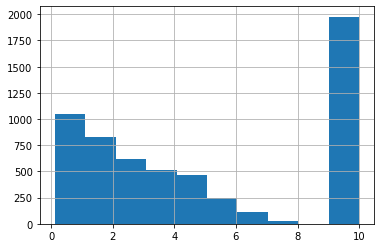

In [18]:
filtered_free_events[filtered_free_events['client_event']=='board_view__shown']['event_score'].hist()

Then *event score* was aggregated as median value for each cohort for each event. Meaning of it - if in every account the particular event is more frequent than other events, it's in demand for accounts in the particular cohort and it has the lowest score.

In [19]:
filtered_free_events.\
    groupby(['client_event','client_group']).aggregate({'event_score': 'median'}).reset_index().sort_values(by='event_score',ascending=True)[:2]

,client_event,client_group,event_score
708,timesheet__open,timesheet,0.307692
389,new_subtask_name__typing,subtasklist,0.312500


In [ ]:
filtered_free_events.head(3)

**But if only one account had an event and it occured frequently in this account, the score for it will be low**

So, when we aggregate this account into cohort with this event, score for event in the whole cohort will be low and this doesn't mean it's popular for every account in cohort

That's why we should calculate frequency of events among all accounts: For each cohort and for each event looked at the share of accounts who had this event (as an example: 74% had event 'edit_title__click', so mostly everyone edited title of the task). 

In [20]:
all_events = filtered_free_events.\
    groupby(['client_event','client_group','account_type'])['cnt_events','account_id', 'event_score'].\
    aggregate({'cnt_events': 'sum', 'account_id': 'nunique', 'event_score': 'median'}).reset_index().sort_values(by='cnt_events',ascending=False)

In [ ]:
all_events.rename(columns={"account_id": "num_accounts"},inplace=True)
all_events.head()

In [ ]:
all_events['account_type'].value_counts()

In [27]:
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("Top events")
ch.set_subtitle("Automatically sorts by value counts.")
ch.plot.bar(
    data_frame=all_events[all_events['cnt_events']>=5000],
    categorical_columns=['account_type','event_group'],
    numeric_column='cnt_events',
    categorical_order_ascending=True)
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

In [28]:
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("Top events")
ch.set_subtitle("Automatically sorts by value counts.")
ch.plot.bar(
    data_frame=all_events[all_events['event_score']<=1],
    categorical_columns=['account_type','event_group'],
    numeric_column='event_score',
    categorical_order_ascending=False)
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

In [ ]:
all_events['event_group'] = all_events['client_event']+' ('+all_events['client_group'] + ')'

events_count_by_acc_type = pd.pivot_table(all_events, values='cnt_events', index=['event_group'],
                    columns=['account_type'], aggfunc=np.sum, fill_value=0)
num_accs_by_events = pd.pivot_table(all_events, values='num_accounts', index=['event_group'],
                    columns=['account_type'], aggfunc=np.sum, fill_value=0)
events_score_by_acc_type = pd.pivot_table(all_events, values='event_score', index=['event_group'],
                    columns=['account_type'], aggfunc=np.sum, fill_value=11)
events_score_by_acc_type.head()

In [23]:
events_count_by_acc_type.shape

(816, 6)

In [24]:
events_count_by_acc_type = events_count_by_acc_type[['paid','free active (3+ weeks) with 2+ users',
                   'free active (>8 weeks) with 1 user','free active (3-8 weeks) with 1 user',
                    'within trial active with 2+ users','non-active after trial end']].\
    sort_values(by=['paid','free active (3+ weeks) with 2+ users',
                                  'free active (>8 weeks) with 1 user','free active (3-8 weeks) with 1 user',
                                  'within trial active with 2+ users','non-active after trial end'],ascending=False)

num_accs_by_events = num_accs_by_events[['paid','free active (3+ weeks) with 2+ users',
                   'free active (>8 weeks) with 1 user','free active (3-8 weeks) with 1 user',
                    'within trial active with 2+ users','non-active after trial end']].\
    sort_values(by=['paid','free active (3+ weeks) with 2+ users',
                                  'free active (>8 weeks) with 1 user','free active (3-8 weeks) with 1 user',
                                  'within trial active with 2+ users','non-active after trial end'],ascending=False)

events_score_by_acc_type = events_score_by_acc_type[['paid','free active (3+ weeks) with 2+ users',
                   'free active (>8 weeks) with 1 user','free active (3-8 weeks) with 1 user',
                    'within trial active with 2+ users','non-active after trial end']].\
    sort_values(by=['paid','free active (3+ weeks) with 2+ users',
                                  'free active (>8 weeks) with 1 user','free active (3-8 weeks) with 1 user',
                                  'within trial active with 2+ users','non-active after trial end'],ascending=True)

In [ ]:
num_accs_by_events.head()

In [ ]:
events_count_by_acc_type.iloc[:,0:].describe()

In [ ]:
events_score_by_acc_type.iloc[:,0:].describe()

In [25]:
events_count_by_acc_type = events_count_by_acc_type[events_count_by_acc_type['non-active after trial end']>10]
events_count_by_acc_type.shape

(334, 6)

In [26]:
events_count_by_acc_type_T = events_count_by_acc_type.T

In [27]:
events_count_by_acc_type_share = events_count_by_acc_type_T.div(events_count_by_acc_type_T.sum(axis=1), axis=0).T

In [28]:
num_accs_by_events_T = num_accs_by_events.T
num_accs_by_events_share = num_accs_by_events_T.div(num_accs_by_events_T.max(axis=1), axis=0).T

In [ ]:
num_accs_by_events_share.describe()

In [ ]:
num_accs_by_events.max(axis=0)

In [30]:
for col in num_accs_by_events_share.columns:
    num_accs_by_events_share[col] = num_accs_by_events_share[col].apply(lambda x: 0.001 if x==0 else x)

In [31]:
num_accs_by_events_share.head(2)

account_type,paid,free active (3+ weeks) with 2+ users,free active (>8 weeks) with 1 user,free active (3-8 weeks) with 1 user,within trial active with 2+ users,non-active after trial end
event_group,,,,,,
tableview_open__view (table2),1.000000,0.920732,0.914634,0.894488,0.856115,0.92627
board_view__shown (boards),0.904762,1.000000,0.969512,1.000000,1.000000,1.00000


And the final step is to make **integrated event score** - it's multiplication of event score and 1 / share of accounts (in the range 0-1). Meaning 1 / share of accounts - if all accounts have the particular event (90%) it will be 1/0.90 = 1,1 but if only several accounts in cohort have it (5%) 1/0.05 = 20. 

And when we multiply it by event score described above we get that the lower score - the more accounts have it at the highest frequency:

* if event occured frequently in most of the accounts - it has low event score (0.4) and if most of the accounts had it (like 90%) the integrated event score will be 0.4 * (1/0.9) = 0.444
* if event occured frequently in most of the accounts - it has low event score (0.4) and if only one account had it (like 0.1%) the integrated event score will be 0.4 * (1/0.001) = 400
* if event occured once in most of the accounts - it has high event score (10) and if only one account had it (like 0.1%) the integrated event score will be 10 * (1/0.001) = 10000

In [32]:
events_final_score_by_acc_type = round(events_score_by_acc_type.mul(1/num_accs_by_events_share, fill_value=100),1)

In [33]:
events_final_score_by_acc_type.sort_values(by='paid',ascending=True).head(2)

account_type,paid,free active (3+ weeks) with 2+ users,free active (>8 weeks) with 1 user,free active (3-8 weeks) with 1 user,within trial active with 2+ users,non-active after trial end
event_group,,,,,,
new_subtask_name__typing (subtasklist),1.4,25.7,32.5,82.2,103.3,256.0
board_view__shown (boards),1.4,1.4,2.2,2.3,2.6,5.0


**RMSE for new super metric** to identify which groups have the biggest difference

In [ ]:
from sklearn.metrics import mean_squared_error

rmse_df = pd.DataFrame(columns=['acc_type1', 'acc_type2','rmse'])
for col1 in events_final_score_by_acc_type.columns:
    for col2 in events_final_score_by_acc_type.columns:
        if col1 != col2:
            rmse = mean_squared_error(events_final_score_by_acc_type[col1].apply(lambda x: np.sqrt(x)), 
                         events_final_score_by_acc_type[col2].apply(lambda x: np.sqrt(x)), squared=False)
            rmse_df = rmse_df.append({'acc_type1': col1, 'acc_type2': col2, 'rmse':rmse}, ignore_index=True)
rmse_df.head(6)

In [55]:
ch = chartify.Chart(
        blank_labels=True,
        x_axis_type='categorical',
        y_axis_type='categorical')
ch.plot.heatmap(
        data_frame=rmse_df,
        x_column='acc_type1',
        y_column='acc_type2',
        color_column='rmse',
        text_column='rmse',
        text_color='white')
ch.axes.set_xaxis_label('Account Type').\
    axes.set_yaxis_label('Account Type').\
    set_title('Heatmap').\
    axes.set_xaxis_tick_orientation('vertical').\
    show()

## Exploratory analysis of events between groups

#### Difference in events between paid and free active with 1 user (3-8 weeks)

In [ ]:
diff = events_final_score_by_acc_type['paid'] - events_final_score_by_acc_type['free active (3+ weeks) with 2+ users']
diff.describe()

In [61]:
mask = (diff <-1000)
events_diff = pd.DataFrame(diff[mask].sort_values(ascending=True)[80:120],columns = ['diff share']).reset_index()
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_subtitle("Top 1-40 differentiated events in paid compared to free active (3+ weeks) with 2+ users")
ch.plot.bar(
    data_frame=events_diff,
    categorical_columns=['event_group'],
    numeric_column='diff share',
    categorical_order_ascending=False)
ch.figure.height = 600
ch.figure.width = 1000
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

#### Difference in events between free active (3+ weeks) with 2+ users and within trial active with 2+ users

In [113]:
s = (events_final_score_by_acc_type['free active (3+ weeks) with 2+ users'] - \
        events_final_score_by_acc_type['within trial active with 2+ users'])
# diff = s.where((s>0)|(s<0),0.001)
diff = s

In [117]:
mask = ((diff > -1000)|(diff < 1000))
events_diff = pd.DataFrame(diff[mask].sort_values(ascending=True)[200:240],columns = ['diff share']).reset_index()
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_subtitle("Top 40-80 differentiated events in free active (3+ weeks) compared to within trial active with 2+ users")
ch.plot.bar(
    data_frame=events_diff,
    categorical_columns=['event_group'],
    numeric_column='diff share',
    categorical_order_ascending=False)
ch.figure.height = 600
ch.figure.width = 1000
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

In [ ]:
events_diff[-20:]

## Exploratory analysis of events for different groups

#### **Paid**

In [134]:
df_events = events_count_by_acc_type[['paid']].sort_values(by='paid',ascending=False).reset_index()
df_accs = num_accs_by_events_share[num_accs_by_events_share['paid']>0.2][['paid']].\
            sort_values(by='paid',ascending=False).reset_index()
df_scores = events_score_by_acc_type[events_score_by_acc_type['paid']<5][['paid']].\
            sort_values(by='paid',ascending=True).reset_index()
df_final_scores = events_final_score_by_acc_type[events_final_score_by_acc_type['paid']<100][['paid']].\
            sort_values(by='paid',ascending=True).reset_index()

In [137]:
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("Top 30-60 events for paid")
ch.set_subtitle("Sorts by integrated event score (the lower score - the more recurring event in most of accs)")
ch.plot.bar(
    data_frame=df_final_scores[30:60],
    categorical_columns=['event_group'],
    numeric_column='paid',
    categorical_order_ascending=False)
ch.figure.height = 600
ch.figure.width = 1000
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

In [136]:
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("Top 1-30 events for paid")
ch.set_subtitle("Sorts by integrated event score (the lower score - the more recurring event in most of accs)")
ch.plot.bar(
    data_frame=df_final_scores[0:30],
    categorical_columns=['event_group'],
    numeric_column='paid',
    categorical_order_ascending=False)
ch.figure.height = 600
ch.figure.width = 1000
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

In [139]:
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("Top 60-90 events for paid")
ch.set_subtitle("Sorts by integrated event score (the lower score - the more recurring event in most of accs)")
ch.plot.bar(
    data_frame=df_final_scores[60:90],
    categorical_columns=['event_group'],
    numeric_column='paid',
    categorical_order_ascending=False)
ch.figure.height = 600
ch.figure.width = 1000
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

In [133]:
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("Top events for paid")
ch.set_subtitle("Sorts by share of accs with this event among all")
ch.plot.bar(
    data_frame=df_accs[0:30],
    categorical_columns=['event_group'],
    numeric_column='paid',
    categorical_order_ascending=True)
ch.figure.height = 600
ch.figure.width = 1000
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

#### **Free active (3+ weeks) with 2+ users**

In [32]:
df_events = events_count_by_acc_type[['free active (3+ weeks) with 2+ users']].\
        sort_values(by='free active (3+ weeks) with 2+ users',ascending=False)[0:30].reset_index()
df_accs = num_accs_by_events_share[num_accs_by_events_share['free active (3+ weeks) with 2+ users']>0.2]\
                [['free active (3+ weeks) with 2+ users']].\
            sort_values(by='free active (3+ weeks) with 2+ users',ascending=False).reset_index()
df_scores = events_score_by_acc_type[events_score_by_acc_type['free active (3+ weeks) with 2+ users']<5]\
                [['free active (3+ weeks) with 2+ users']].\
            sort_values(by='free active (3+ weeks) with 2+ users',ascending=True).reset_index()
df_final_scores = events_final_score_by_acc_type[events_final_score_by_acc_type['free active (3+ weeks) with 2+ users']<100]\
            [['free active (3+ weeks) with 2+ users']].\
            sort_values(by='free active (3+ weeks) with 2+ users',ascending=True).reset_index()

In [67]:
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("Top events")
ch.set_subtitle("Automatically sorts by value counts.")
ch.plot.bar(
    data_frame=df_events,
    categorical_columns=['event_group'],
    numeric_column='free active (3+ weeks) with 2+ users',
    categorical_order_ascending=True)
ch.figure.height = 600
ch.figure.width = 1000
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

In [132]:
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("Top 40 events for free active (3+ weeks) with 2+ users")
ch.set_subtitle("Sorts by event score (the lower score - more frequent event)")
ch.plot.bar(
    data_frame=df_final_scores[1:41],
    categorical_columns=['event_group'],
    numeric_column='free active (3+ weeks) with 2+ users',
    categorical_order_ascending=False)
ch.figure.height = 600
ch.figure.width = 1000
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

In [133]:
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("Top 41-80 events for free active (3+ weeks) with 2+ users")
ch.set_subtitle("Sorts by event score (the lower score - more frequent event)")
ch.plot.bar(
    data_frame=df_final_scores[41:81],
    categorical_columns=['event_group'],
    numeric_column='free active (3+ weeks) with 2+ users',
    categorical_order_ascending=False)
ch.figure.height = 600
ch.figure.width = 1000
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

In [ ]:
df_final_scores[0:41].head(3)

#### **Free active (>8 weeks) with 1 user**

In [69]:
df_events = events_count_by_acc_type[['free active (>8 weeks) with 1 user']].\
        sort_values(by='free active (>8 weeks) with 1 user',ascending=False).reset_index()
df_accs = num_accs_by_events_share[num_accs_by_events_share['free active (>8 weeks) with 1 user']>0.2]\
                [['free active (>8 weeks) with 1 user']].\
            sort_values(by='free active (>8 weeks) with 1 user',ascending=False).reset_index()
df_scores = events_score_by_acc_type[events_score_by_acc_type['free active (>8 weeks) with 1 user']<5]\
                [['free active (>8 weeks) with 1 user']].\
            sort_values(by='free active (>8 weeks) with 1 user',ascending=True).reset_index()

In [71]:
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("Top 30 events for free active (>8 weeks) with 1 user")
ch.set_subtitle("Sorts by event score (the lower score - more frequent event)")
ch.plot.bar(
    data_frame=df_scores[5:35],
    categorical_columns=['event_group'],
    numeric_column='free active (>8 weeks) with 1 user',
    categorical_order_ascending=False)
ch.figure.height = 600
ch.figure.width = 1000
ch.axes.set_yaxis_tick_orientation('horizontal')
ch.show()

## Decision tree for top events

What events can 'predict' the retention of users on 3 week of use with 2+ active users?

In [ ]:
filtered_free_events.head(2)

In [ ]:
filtered_free_events.\
    groupby(['account_type']).\
    aggregate({'account_id': 'nunique'}).reset_index().sort_values(by='account_id',ascending=True)

In [ ]:
def is_retained_long(account_type):
    if account_type == 'free active (3+ weeks) with 2+ users':
        return 1
    else:
        return 0
df = filtered_free_events[filtered_free_events['account_type'].\
                              isin(['free active (3+ weeks) with 2+ users','within trial active with 2+ users'])]
df['is_retained_long'] = df.apply(lambda x: is_retained_long(x['account_type']),axis=1)
df.head(2)

In [35]:
df.shape

(37535, 17)

In [36]:
top_events = df_final_scores.iloc[0:61,0]
df = df[df['event_group'].isin(top_events)]

In [ ]:
df.head(2)

In [38]:
df_cnt_events = pd.pivot_table(df, values=['cnt_events'], 
                   index=['account_id','is_retained_long','avg_active_users_view','avg_active_users_edit'],
                   columns=['event_group'], 
                   aggfunc={'cnt_events': np.sum}, fill_value=0)
df_event_score = pd.pivot_table(df, values=['event_score'], 
                   index=['account_id','is_retained_long','avg_active_users_view','avg_active_users_edit'],
                   columns=['event_group'], 
                   aggfunc={'event_score': np.median}, fill_value=0)

In [39]:
df_cnt_events = df_cnt_events.droplevel(0, axis=1).reset_index()

In [ ]:
df_cnt_events.head(2)

In [ ]:
df_cnt_events.loc[:,'avg_active_users_view':].head()

In [42]:
df_cnt_events.shape

(1106, 65)

Teaching models

In [43]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import GradientBoostingClassifier

Cross-validation

In [44]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

For drawing the tree

In [45]:
from six import StringIO
from IPython.display import Image  
import pydotplus
import graphviz
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

Model evaluation

In [46]:
from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

Feature importance

In [47]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [48]:
activity_columns = df_cnt_events.loc[:,'avg_active_users_view':].columns
df_cnt_events[['is_retained_long']]=df_cnt_events[['is_retained_long']].astype('int64')
df_input = df_cnt_events[activity_columns]
df_output = df_cnt_events[['is_retained_long']]

In [49]:
inputs_train, inputs_test, expected_output_train, expected_output_test = \
    train_test_split(df_input, df_output, test_size = 0.15, random_state = 42)

In [ ]:
model = tree.DecisionTreeClassifier(random_state=42,
                               criterion='gini',
                               max_depth=5,
                               min_samples_split=70,
                               min_samples_leaf=20,
                               class_weight='balanced',
                               presort=False)
model.fit(inputs_train, expected_output_train)

In [116]:
accuracy = model.score(inputs_test, expected_output_test)
print("Accuracy = {}%".format(accuracy * 100))

Accuracy = 77.71084337349397%


In [117]:
model.classes_

array([0, 1])

In [118]:
from sklearn.tree import export_graphviz
export_graphviz(
    model,  
    out_file        = 'tree.dot',
    feature_names   = activity_columns,
    class_names     = ['did not retain','retained 3+ weeks'],
    filled          = True,
    rounded         = True
)

In [ ]:
fig, ax = plt.subplots(figsize=(50, 20), facecolor='k')
tree.plot_tree(model,
               feature_names = activity_columns, 
               class_names=['did not retain','retained 3+ weeks'],filled = True, rotate=True, ax=ax);
# plt.show()

In [85]:
import math
n_tree=300
nodesize=10
mtry=math.floor(math.sqrt(len(inputs_train)-1))
#class_weight = dict({'churned':1.9, 'no change':35, 'downgrade':180,'upgrade':})

In [122]:
#class_weight='balanced'
rf = RandomForestClassifier(bootstrap=True,class_weight='balanced',
                             n_estimators=n_tree,min_samples_leaf=nodesize,
                             criterion='gini',random_state=42)
rf.fit(inputs_train, expected_output_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                       n_estimators=300, random_state=42)

In [121]:
accuracy = rf.score(inputs_test, expected_output_test)
print("Accuracy = {}%".format(round(accuracy,4) * 100))

Accuracy = 80.12%


In [88]:
def show_plot_confusion_matrix(model, inputs, outputs, class_names=['did not retain','retained 3+ weeks']):
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, inputs, outputs,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

**Train**

Confusion matrix, without normalization
[[419  61]
 [ 76 384]]
Normalized confusion matrix
[[0.87291667 0.12708333]
 [0.16521739 0.83478261]]


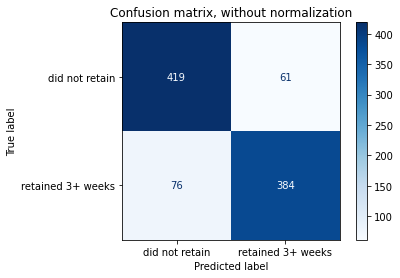

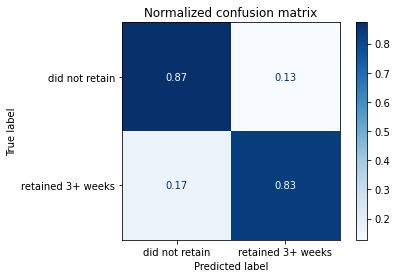

In [89]:
show_plot_confusion_matrix(rf, inputs_train, expected_output_train)

**Test**

Confusion matrix, without normalization
[[69 14]
 [17 66]]
Normalized confusion matrix
[[0.8313253  0.1686747 ]
 [0.20481928 0.79518072]]


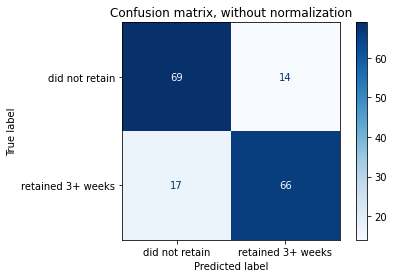

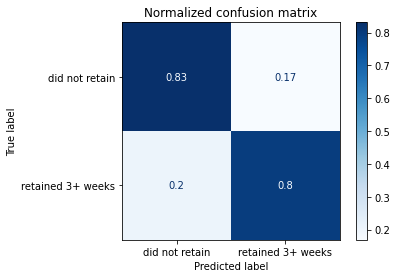

In [90]:
show_plot_confusion_matrix(rf, inputs_test, expected_output_test)

What events are importnat in predicting?

#### Feature importance

In [ ]:
pd.DataFrame({'feature': activity_columns,
              'importance': rf.feature_importances_.round(3)*100}).sort_values('importance', ascending=False).head(40)

**Find best parameters with GridSearch for CTR**

In [ ]:
model = tree.DecisionTreeClassifier(random_state=42,
                               criterion='gini',
                               max_depth=5,
                               min_samples_split=70,
                               min_samples_leaf=20,
                               class_weight='balanced',
                               presort=False)
model.fit(inputs_train, expected_output_train)

In [127]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 10, num = 4)]
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 30, 40, 50 , 60, 70]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 20, 30]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
#criterion for decision tree
criterion = ["gini", "entropy"]
class_weight = ["balanced"]
# Create the random grid
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion,
               'class_weight': class_weight}
print(random_grid)

{'max_depth': [3, 5, 7, 10], 'min_samples_split': [10, 20, 30, 40, 50, 60, 70], 'min_samples_leaf': [5, 10, 20, 30], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced']}


In [128]:
# Use the random grid to search for best hyperparameters
tree = DecisionTreeClassifier()
# Random search of parameters, using cross validation with suffle, 
# search across 100 different combinations, and use all available cores
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tree_random = RandomizedSearchCV(estimator = tree, param_distributions = random_grid, 
                               n_iter = 100, cv = skf, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
tree_random.fit(inputs_train, expected_output_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.6s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_samples_leaf': [5, 10, 20, 30],
                                        'min_samples_split': [10, 20, 30, 40,
                                                              50, 60, 70]},
                   random_state=42, verbose=2)

In [129]:
tree_random.best_params_

{'min_samples_split': 70,
 'min_samples_leaf': 10,
 'max_depth': 10,
 'criterion': 'gini',
 'class_weight': 'balanced'}

In [130]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = metrics.accuracy_score(test_labels, predictions)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

base_model = DecisionTreeClassifier(random_state = 42)
base_model.fit(inputs_train, expected_output_train)
base_accuracy = evaluate(base_model, inputs_test, expected_output_test)

Model Performance
Accuracy = 0.75%.


In [ ]:
df_cnt_events.columns

**An attempt to isolate the rule for product-qualified lead based on important event**

In [176]:
pql = ((df_cnt_events['edit_title__click (taskview)']>=1)&
    ((df_cnt_events['add_assignee__click (taskview)']>=1)|(df_cnt_events['comment__sent (comment_field)']>=1))&
    (df_cnt_events['new_task__created (task_list)']>=1)&(df_cnt_events['avg_active_users_view']>=2))

In [184]:
pql2 = ((df_cnt_events['edit_title__click (taskview)']>=1)|
    (df_cnt_events['add_assignee__click (taskview)']>=1)|(df_cnt_events['comment__sent (comment_field)']>=1)|
    (df_cnt_events['new_task__created (task_list)']>=1))&(df_cnt_events['avg_active_users_view']>=2)

In [177]:
df_cnt_events['pql'] = np.where(pql, 1, 0)
df_cnt_events['pql'].value_counts()

0    683
1    423
Name: pql, dtype: int64

In [185]:
df_cnt_events['pql2'] = np.where(pql2, 1, 0)
df_cnt_events['pql2'].value_counts()

1    937
0    169
Name: pql2, dtype: int64

In [178]:
C = confusion_matrix(df_cnt_events['is_retained_long'], df_cnt_events['pql'],labels=[1, 0])
C

array([[326, 217],
       [ 97, 466]])

In [186]:
C = confusion_matrix(df_cnt_events['is_retained_long'], df_cnt_events['pql2'],labels=[1, 0])
C

array([[523,  20],
       [414, 149]])

In [183]:
n_C = C*100 / C.astype(np.float).sum(axis=1, keepdims=True)
n_C.round(1)

array([[60. , 40. ],
       [17.2, 82.8]])

In [175]:
C.astype(np.float).sum(axis=1)

array([543., 563.])